In [1]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# custom module imports
from acquire import acquire_zillow_data
from prepare import remove_outliers, prepare_zillow
from wrangle import wrangle_zillow, scale_data
from explore import *
from model import * 

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

from mitosheet import *
import plotly.express as px
# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def wrangle_zillow2(target):
    ''' 
    '''
    train, validate, test = prepare_zillow(acquire_zillow_data())
    
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    # Change series into data frame for y 
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [3]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow2('tax_value')

Using cached CSV
Undergoing preparatory stage: 

199 null values removed. 
 52,319 rows remain.
 
Yearbuilt converted to age. 

 Federal Information Processing Standard Publication (FIPS) 
 reveals this Zillow data deals with three counties: 
 Los Angeles (06037), Orange (06059), and Ventura (06111). 
 Hence, data pertains only to Southern California. 

Outliers removed individually on a county-by-county basis. 
 County data recombined accordingly. 
 DF row-based percentage loss after outlier eradication: 19.13%. 

(23524, 7) (10082, 7) (8402, 7)


In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

In [5]:
def scaling_impact(X_train, X_train_scaled):
    plt.figure(figsize=(13, 6))
    plt.subplot(121)
    plt.hist(X_train, bins=25, ec='black')
    plt.title('Original')
    plt.subplot(122)
    plt.hist(X_train_scaled, bins=25, ec='black')
    plt.title('Scaled')

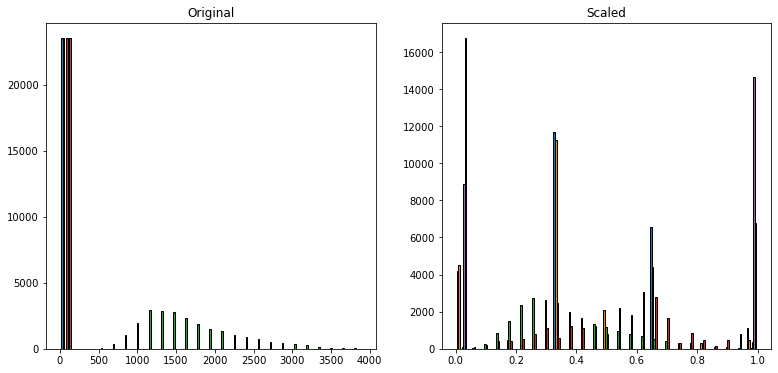

In [6]:
scaling_impact(X_train, X_train_scaled)

In [7]:
def select_rfe(X_train_scaled, y_train, k, return_rankings=False, model=LinearRegression()):
    # Use the passed model, LinearRegression by default
    rfe = RFE(model, n_features_to_select=k)
     # fit the data using RFE
    rfe.fit(X_train_scaled, y_train)
    # get mask of columns selected as list
    feature_mask = X_train_scaled.columns[rfe.support_].tolist()
    if return_rankings:
        rankings = pd.Series(dict(zip(X_train_scaled.columns, rfe.ranking_)))
        return feature_mask, rankings
    else:
        return feature_mask

In [8]:
features_to_use, feature_rankings = select_rfe(X_train_scaled, y_train, 5, return_rankings=True)

In [9]:
#print(feature_rankings.sort_values())
print(' \n Use the following features: \n')
print(feature_rankings)
features = ['beds', 'baths', 'area', 'age', 'los_angeles']

 
 Use the following features: 

beds           1
baths          1
area           1
age            1
los_angeles    1
orange         2
dtype: int64


In [10]:
# 1. Predict mean tax value 
tv_pred_mean = y_train.tax_value.mean()
y_train['tv_pred_mean'] = tv_pred_mean
y_validate['tv_pred_mean'] = tv_pred_mean

# 2. Predict median tax value 
tv_pred_median = y_train.tax_value.median()
y_train['tv_pred_median'] = tv_pred_median
y_validate['tv_pred_median'] = tv_pred_median

# 3. RMSE of tv_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tv_pred_median
rmse_train1 = mean_squared_error(y_train.tax_value, y_train.tv_pred_median) ** .5
rmse_validate1 = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 2))

RMSE using Mean
Train/In-Sample:  244358.79 
Validate/Out-of-Sample:  247383.7
-----------
RMSE using Median
Train/In-Sample:  246614.86 
Validate/Out-of-Sample:  249653.86


In [11]:
# add the mean baseline to a df to help evaluate all models side by side
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_mean)}])

In [12]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.0


In [13]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# use only the features we selected
lm.fit(X_train_scaled[features], y_train.tax_value)

# predict train
# 
# use the thing!
# 
y_train['tv_pred_lm'] = lm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm) ** (1/2)

# predict validate
y_validate['tv_pred_lm'] = lm.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  211815.74555149165 
Validation/Out-of-Sample:  213948.6103911231


In [14]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'OLS lm',
    'rmse_outofsample': rmse_validate,
        'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_lm)}, ignore_index=True)

In [15]:
#Tweedie Regressor GLM
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series

glm.fit(X_train_scaled[features], y_train.tax_value)

# predict train
y_train['tv_pred_glm'] = glm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm) ** (1/2)


# predict validate
y_validate['tv_pred_glm'] = glm.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_glm) ** (1/2)


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  237778.34731167604 
Validation/Out-of-Sample:  240893.92232643464


In [16]:
# add model to metric df
metric_df = metric_df.append(
    {
    'model': 'Tweedie GLM power 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_glm)}, ignore_index=True)

In [17]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train_scaled[features], y_train.tax_value)

# predict train
y_train['tv_pred_lars'] = lars.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lars) ** (1/2)

# predict validate
y_validate['tv_pred_lars'] = lars.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  211816.0944804274 
Validation/Out-of-Sample:  213952.88164697244


In [18]:
# add model to metric df
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_lars)}, ignore_index=True)

In [19]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.000000
1,OLS lm,213948.610391,0.252141
2,Tweedie GLM power 1,240893.922326,0.051778
3,LassoLars alpha 1,213952.881647,0.252111


In [20]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = pf.fit_transform(X_train_scaled[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[features])
X_test_degree2 = pf.transform(X_test_scaled[features])

pm = LinearRegression(normalize=True)

pm.fit(X_train_degree2, y_train.tax_value)

y_train['tv_pred_pm'] = pm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_pm) ** (1/2)

# predict validate
y_validate['tv_pred_pm'] = pm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_pm) ** (1/2)

print("RMSE for PolynomialRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for PolynomialRegression
Training/In-Sample:  206432.94619925288 
Validation/Out-of-Sample:  208890.0469949978


In [21]:
metric_df = metric_df.append(
    {
    'model': 'PolyReg Model',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_pm)}, ignore_index=True)
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,247383.703403,0.000000
1,OLS lm,213948.610391,0.252141
2,Tweedie GLM power 1,240893.922326,0.051778
3,LassoLars alpha 1,213952.881647,0.252111
4,PolyReg Model,208890.046995,0.287012


In [22]:
# Fit best performing model on TestSplit
# predict on test
y_test['tv_pred_pm'] = pm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tv_pred_pm) ** (1/2)
print("RMSE for Model using PolynomialRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using PolynomialRegression
Out-of-Sample Performance:  207607.05439575057


In [23]:
metric_df = metric_df.append(
    {
    'model': 'Test',
    'rmse_outofsample': rmse_test,
    'r^2_outofsample': explained_variance_score(y_test.tax_value, y_test.tv_pred_pm)}, ignore_index=True)